First we need to import all of our data.

In [57]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Read in the data
conditionData = []
controlData = []
scores = pd.read_csv("data/scores.csv")

for fileName in os.listdir("data/condition"):
	conditionData.append(pd.read_csv(f"data/condition/{fileName}"))
for fileName in os.listdir(f"data/control"):
	controlData.append(pd.read_csv(f"data/control/{fileName}"))


Now we need to combine our motor activity in one file with the labels indicating if it is a condition or control

In [58]:
df = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	temp = {'Activity': [data.activity.tolist()], 'TimeStamp': [data.timestamp.tolist()], 'Target': "condition"}
	activity = data.activity
	activity = np.array(activity)
	dfTemp = pd.DataFrame(temp)
	df = pd.concat([df, dfTemp])

for data in controlData:
	temp = {'Activity': [data.activity.tolist()], 'TimeStamp': [data.timestamp.tolist()], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	# print(temp)
	df = pd.concat([df, dfTemp])
	activity = data.activity
	activity = np.array(activity)


print(df)


                                            Activity  \
0  [0, 143, 0, 20, 166, 160, 17, 646, 978, 306, 2...   
0  [91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
0  [0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
0  [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [0, 0, 0, 0, 0, 3, 0, 233, 0, 0, 0, 0, 0, 0, 0...   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [249, 69, 116, 258, 152, 142, 467, 711, 360, 4...   
0  [1468, 1006, 468, 306, 143, 205, 410, 349, 566...   
0  [97, 498, 249, 396, 209, 240, 54, 54, 55, 12, ...   
0  [0, 349, 111, 38, 3, 79, 296, 8, 0, 0, 52, 0, ...   
0  [111, 66, 157, 73, 142, 131, 137, 5, 107, 223,...   
0  [161, 80, 175, 728, 911, 151, 121, 23, 96, 25,...   
0  [7, 8, 7, 8, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8,

Split our data into training/testing

In [59]:
y = df.iloc[:,-1:]
x = df.iloc[: , :-1]

y = np.array(y)
x = np.array(x)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
sss.get_n_splits(x, y)
for train_index, test_index in sss.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


### Showing a person's daily activity:

What does the activity of a person look like over the time they participated in the experiment? We can pretty easily tell from the graphs below the times that a person was asleep. These times are characterized by log periods of really low activity levels. Additionally we can see peaks of activity that could show when a person exercised.

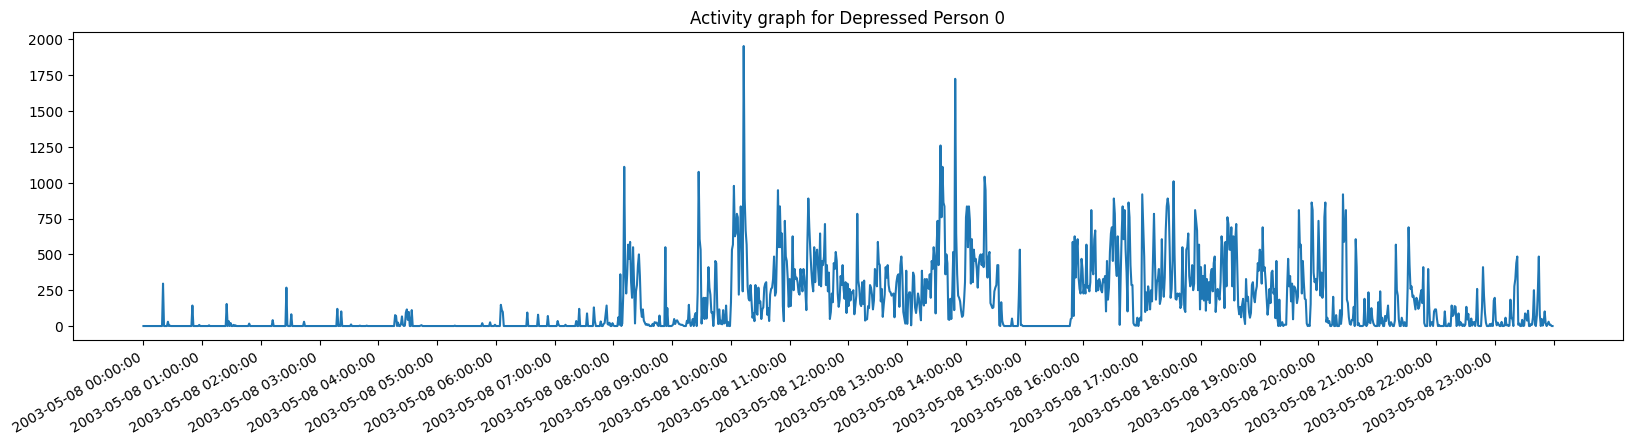

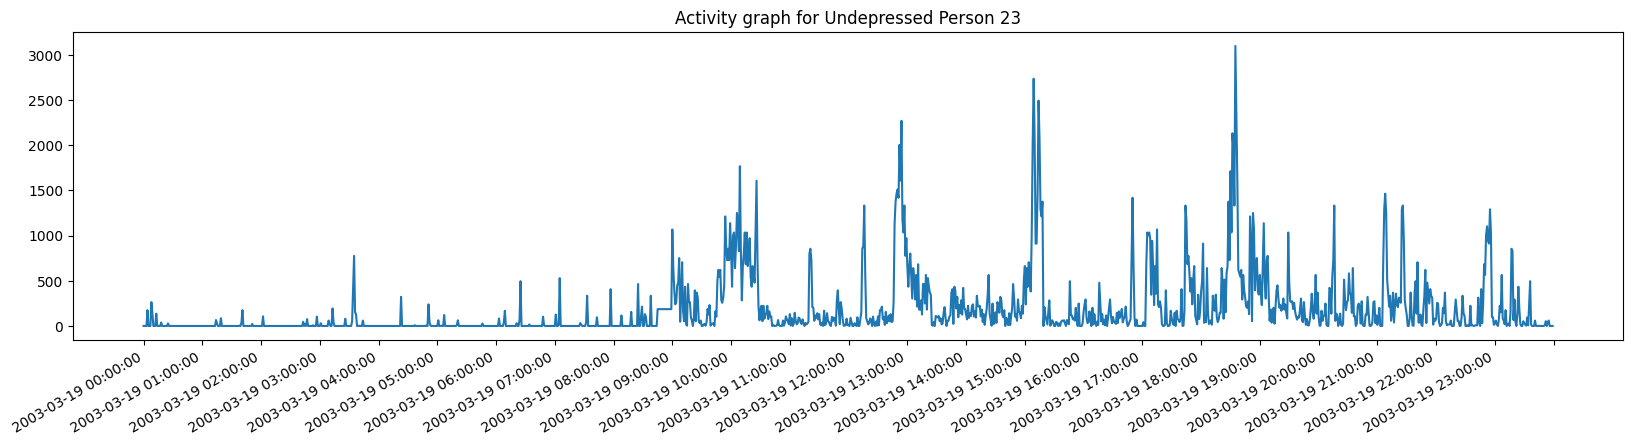

In [60]:

from datetime import datetime

def graph_person_activity(person, hours_to_display=24, start_time_str=""):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(4)

    # Find the first instance of the specified starttime to begin graphing our data
    beginIndex = 0
    if start_time_str != "":
        c = 0
        for timestamp in df.TimeStamp.tolist()[person]:
            if timestamp.endswith(start_time_str):
                beginIndex = c
                break
            c += 1
        if c >= len(df.TimeStamp.tolist()[person]):
            print("Error: Could not find specified Start Time: " + start_time_str)
            print("Defaulting to beginning of test data")
    
    # Display the activity of the person in our Datase for the number of hours selected beginning at the first applicable start time.
    plt.title(f"Activity graph for Depressed Person {person}" if df.Target.tolist()[person] == 'condition' else f"Activity graph for Undepressed Person {person}")
    plt.plot(df.TimeStamp.tolist()[person][beginIndex : beginIndex+(60*hours_to_display)], df.Activity.tolist()[person][beginIndex: beginIndex + (60*hours_to_display)])
    plt.xticks(np.arange(0, (60*hours_to_display)+ 1, 60), rotation=30, ha='right') # set xticks to every hour instead of every minute
    plt.show()


# Graph activity for first Depressed individual
graph_person_activity(0, 24, "00:00:00")
# Graph Activity for first Control individual
graph_person_activity(23, 24, "00:00:00")


### Use a Random Forest Classifier.

In [61]:
clf=RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train.ravel())
accuracy = clf.score(X_test, y_test)
print(accuracy)

ValueError: setting an array element with a sequence.

Our classifier isn't very good. Hits around 66% with a .3 split. We might want to clean the data a bit more or use a different classifier.

### Exercise and Classifying Depression

Scientists have said that getting 30 minutes of Exercise each day is beneficial to mental health. We can get the sum of the highest consecutive 30 minutes every day to determine an 'Exercise Score' for each person each day they participated in the experiment.

In [64]:
# take a persons total activity log and split into "days" or 24 hours
# find max sum of 30 consecutive minutes and put that as a time series value. 
import math


exerciseScores = []
for person in df.Activity.tolist():
    personScores = []
    dayCount = len(person)//(24*60)
    for i in range(0, dayCount): # for each day the person participated
        maxActivity = -1
        startOfDay = i * (24*60)
        endOfDay = min(i * (24*60) + (24*60), len(person)-1)
        for j in range(startOfDay, endOfDay- 30): # for each minute in the specific day. (except the last 30 minutes)
            score = sum(person[j : j+30]) # Get the sum of the activity for the 30 minutes
            if score > maxActivity: # if this is the max then save it as the max
                maxActivity = score
        personScores.append(maxActivity) # append Score to person scores
    
    exerciseScores.append(personScores) # append each person's score TS to the exercise scores

# Clean up exercise scores by removing bad data. (Any data where the max activity for the entire day was less than 1000) 
# The reason we would get anything less than 1000 is if the person did not move at all through the whole day, or they 
# had a bad sensor.
# for p in exerciseScores:
#     trash = []
#     for s in p:
#         if s <= 1000:
#             trash.append(s)
#     for t in trash:
#         p.remove(t)

minlen = min(len(i) for i in exerciseScores)
# create a TS with mean, std, min, and max to make each have the same length
exerciseStats = []
for person in exerciseScores:
	temp = [np.average(person), np.std(person), min(person), max(person)]
	exerciseStats.append(temp)
    


In [106]:
y = np.array(y)
x = np.array(exerciseStats)

a = []
for _ in range(100):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
    sss.get_n_splits(x, y)
    for train_index, test_index in sss.split(x, y):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]


    clf=RandomForestClassifier(n_estimators=10)
    clf.fit(X_train, y_train.ravel())
    accuracy = clf.score(X_test, y_test)
    a.append(accuracy)
print("Average Accuracy:", np.average(a))

Average Accuracy: 0.6452941176470588


Once again we see that we are getting an average classification accuracy of around 64-68%. This likely points out that exercising daily does not have too strong of a coorelation with depression. One can choose to not exercise and not be depressed.

### Sedentary Lifestyle and Depression

Experts say that depressed patients often live sedentary lifestyles where they will not be active during the day. We can see this from a low number count over the time of day. We will use 10 as the threshold for our 'low number'.

### Sleep and Classifying Depression

Experts have said getting 8 hours of restful sleep is essential to good mental health. We can give a rested score of the longest length of low activity for each day. Threshold for low activity will be 10. 